In [ ]:
# Copyright (c) 2024, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import json
import orjson
import random
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import pickle as pkl

from utils import PoissonDiskSampler

In [2]:
DATASET_PATH = '../datasets/'
index_file = 'ADE20K_2021_17_01/index_ade20k.pkl'
with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
    index_ade20k = pkl.load(f)

In [3]:
index_ade20k.keys()

dict_keys(['filename', 'folder', 'objectIsPart', 'objectPresence', 'objectcounts', 'objectnames', 'proportionClassIsPart', 'scene', 'wordnet_found', 'wordnet_level1', 'wordnet_synset', 'wordnet_hypernym', 'wordnet_gloss', 'wordnet_frequency', 'description'])

In [4]:
stuff_words = [
    'sky', 'wall', 'floor', 'ceiling', 'road', 'trees', 'plants', 'buildings',
    'ground','sidewalk', 'grass','sea water', 'water','river water','sand','snow','land'
]

In [5]:
poisson_disk_sampler = PoissonDiskSampler(num_samples=100, radius=0.1)

In [6]:
sel_data = []
for i_img in tqdm(range(27574)):
# for i_img in range(100):
    file_name = index_ade20k['filename'][i_img]
    full_file_name = '{}/{}'.format(index_ade20k['folder'][i_img], index_ade20k['filename'][i_img])
    full_file_path = '{}/{}'.format(DATASET_PATH, full_file_name)
    meta_data_path = full_file_path.replace('.jpg', '.json')

    image_path = '{}/{}'.format(DATASET_PATH, full_file_name)
    image = cv2.imread(image_path)
    image_area = image.shape[0] * image.shape[1]
    
    try:
        with open(meta_data_path.replace('.jpg', '.json')) as f:
            json_data = json.load(f)
    except:
        print('Error reading file, index:', i_img)
        continue
    
    all_objects = {}
    for obj in json_data['annotation']['object']:
        i_obj = obj['id']
        obj_raw_name = obj['raw_name']
        
        if obj_raw_name in stuff_words:
            continue
        
        mask_file = full_file_path.replace('.jpg', '') + f'/instance_{i_obj:03}_{file_name}'.replace('.jpg', '.png')
        # mask = cv2.imread(file_instance)
        
        x_min = min(obj['polygon']['x'])
        x_max = max(obj['polygon']['x'])
        y_min = min(obj['polygon']['y'])
        y_max = max(obj['polygon']['y'])
        bbox = [x_min, y_min, x_max, y_max]
        bbox_area = (x_max - x_min) * (y_max - y_min)
        
        if not obj_raw_name in all_objects:
            all_objects[obj_raw_name] = []
        
        all_objects[obj_raw_name].append({
            'id': i_obj,
            'bbox': bbox,
            'bbox_area_ratio': bbox_area / image_area,
            'mask_oath': mask_file,
        })
        
    for obj_raw_name, objects in all_objects.items():
        if len(objects) > 5:
            continue
        
        if not all(bbox['bbox_area_ratio'] > 0.02 for bbox in objects):
            continue
        
        sel_data.append({
            'image_path': image_path,
            'obj_name': obj_raw_name,
            'objects': objects,
        })
        
        
        # print(obj['raw_name'])
        # plt.imshow(image)
        # plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=2))
        # # plt.imshow(mask, alpha=0.5)
        # plt.show()
    
    # print()
    # break

  0%|          | 0/27574 [00:00<?, ?it/s]

Error reading file, index: 7689
Error reading file, index: 8905
Error reading file, index: 20433
Error reading file, index: 20543
Error reading file, index: 21029
Error reading file, index: 22979
Error reading file, index: 23011
Error reading file, index: 23048
Error reading file, index: 24103
Error reading file, index: 24794


In [7]:
len(sel_data)

93947

In [8]:
sel_data[99]

{'image_path': '/home/ai2lab/work/datasets//ADE20K_2021_17_01/images/ADE/training/home_or_hotel/bathroom/ADE_train_00000020.jpg',
 'obj_name': 'bathtub',
 'objects': [{'id': 13,
   'bbox': [194, 1458, 1484, 1814],
   'bbox_area_ratio': 0.14049192364170338,
   'mask_oath': '/home/ai2lab/work/datasets//ADE20K_2021_17_01/images/ADE/training/home_or_hotel/bathroom/ADE_train_00000020/instance_013_ADE_train_00000020.png'}]}

In [9]:
all_ref_data = []
for d in tqdm(sel_data):
    try:
        image_path = d['image_path'].replace('/home/ai2lab/work/datasets/ADE20K//', '')
        obj_name = d['obj_name']
        phrases = [obj_name]
        
        bboxes = []
        points_and_labels = []
        for obj in d['objects']:
            bbox = obj['bbox']
            mask_path = obj['mask_oath']
            
            gt_mask = (cv2.imread(mask_path).sum(-1) > 0)
            img_h, img_w = gt_mask.shape
            
            scaled_bbox = [bbox[0]/img_w*1000, bbox[1]/img_h*1000, bbox[2]/img_w*1000, bbox[3]/img_h*1000]
            scaled_bbox = [int(round(x)) for x in scaled_bbox]
            scaled_bbox = [
                max(0, scaled_bbox[0]),
                max(0, scaled_bbox[1]),
                min(999, scaled_bbox[2]),
                min(999, scaled_bbox[3]),
            ]
            
            rand_points = poisson_disk_sampler.sample(bbox)
            rand_points = [(int(x), int(y)) for x, y in rand_points]
            on_masks = gt_mask[np.array(rand_points)[:, 1], np.array(rand_points)[:, 0]]
            
            scaled_rand_points = [(x/img_w*1000, y/img_h*1000) for x, y in rand_points]
            scaled_rand_points_on_mask = [(int(x), int(y), int(on_mask)) for (x, y), on_mask in zip(scaled_rand_points, on_masks)]
            
            bboxes.append(scaled_bbox)
            points_and_labels.append(scaled_rand_points_on_mask)
            
        assert len(bboxes) == len(points_and_labels)
        
        all_ref_data.append({
            'image_path': image_path,
            'phrases': phrases,
            'bboxes': bboxes,
            'points_and_labels': points_and_labels,
        })
    except:
        print('Error processing data')
        continue

  0%|          | 0/93947 [00:00<?, ?it/s]

Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error processing data
Error proc

In [10]:
# save with orjson
with open('processed_data_v2/ade20k_ref_data.json', 'w') as f:
    f.write(orjson.dumps(all_ref_data).decode())

In [3]:
with open('processed_data_v2/ade20k_ref_data.json', 'r') as f:
    all_ref_data = orjson.loads(f.read())

['inside arm'] [[71, 641, 198, 964]]


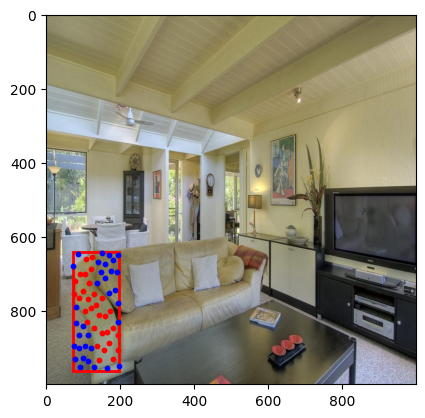

['paper'] [[16, 771, 275, 948]]


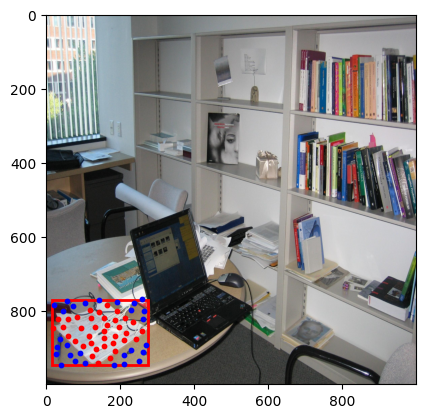

['door'] [[875, 127, 981, 562]]


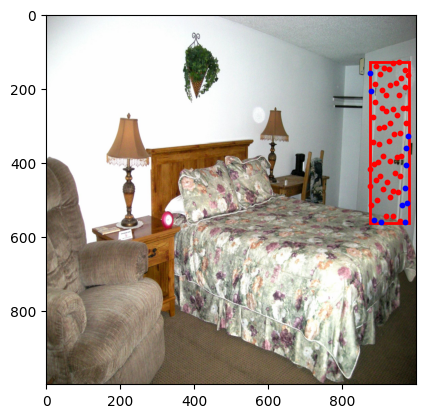

['window'] [[300, 120, 494, 662], [531, 132, 786, 615]]


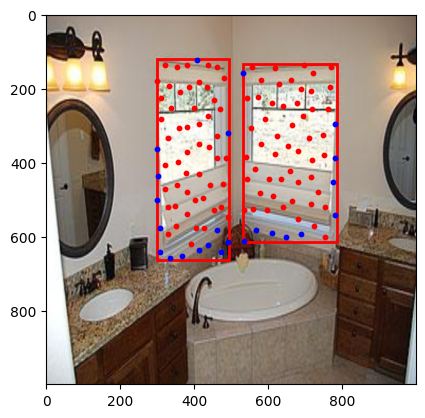

['bathtub'] [[757, 682, 925, 999]]


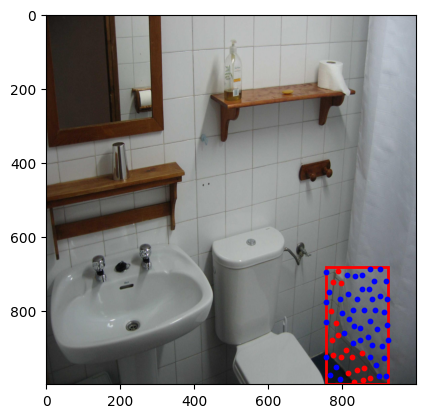

['shelf'] [[825, 4, 998, 139]]


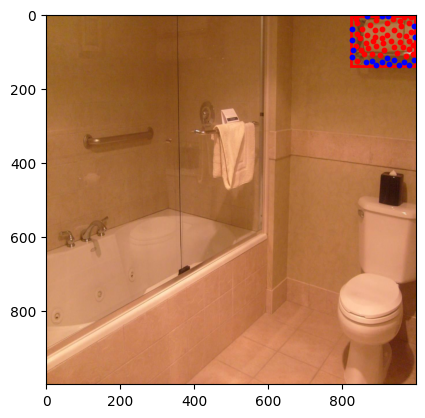

['pane'] [[738, 204, 926, 341]]


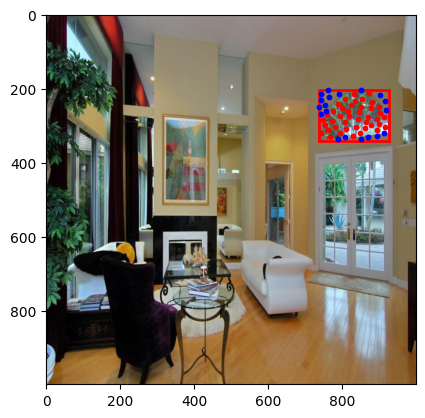

['railing'] [[523, 51, 699, 340]]


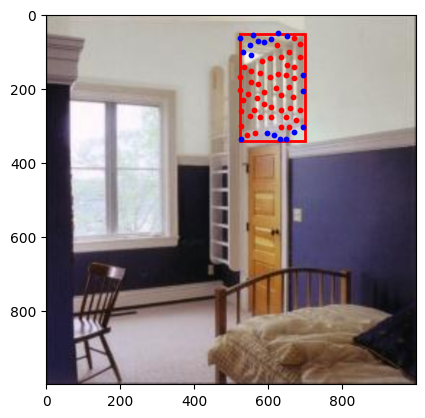

['table'] [[785, 812, 996, 996]]


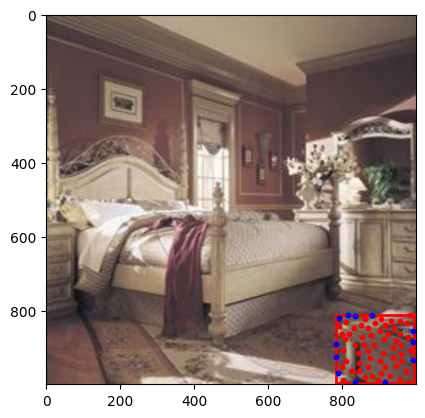

['stove'] [[354, 604, 701, 684]]


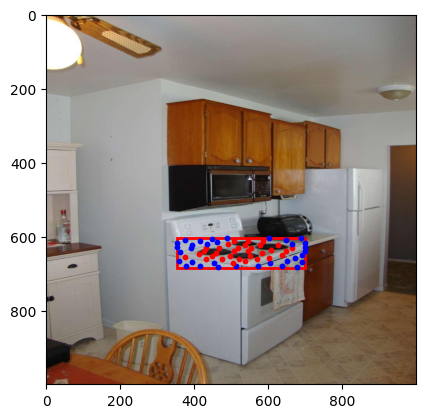

In [8]:
for d in random.sample(all_ref_data, 10):
    image_path = os.path.join(DATASET_PATH, d['image_path'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1000, 1000))
    bboxes = d['bboxes']
    points_and_labels = d['points_and_labels']

    print(d['phrases'], bboxes)
    plt.imshow(image)
    for bbox in bboxes:
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=2))

    for points_and_labels_i in points_and_labels:
        for x, y, on_mask in points_and_labels_i:
            plt.scatter(x, y, c='red' if on_mask else 'blue', s=10)

    plt.show()

In [ ]:
# Counter(gt_mask.reshape(-1).tolist())